> * #### THIS POST SHOULD NOT USE LAMBDA ENVIRONMENT - INSTEAD IT SHOULD BE PURE VOILA DEPLOYMENT.  USE THE 'volgpt-post-temp' setup for the actual post too, BUT CREATE A NEW FOLDER ON HOME AND ARTIFACT REPO CALLED 'volgpt-post'.  Keep volgpt-post-temp (i.e., don't delete it, because it will be useful as a template in future)
> * #### NANOGPT POST SHOWS THE IMPLEMENTATION, NO NEED TO DO THAT AGAIN.  IN THIS POST, JUST FOCUS ON RESULTS

> * #### CONSIDER PUTTING THE MODEL INTO A SEPARATE ARTIFACT REGISTRY IMAGE - I.E., RUN THE MODEL AS A SERVICE, THEN CALL THE MODEL'S OUTPUTS IN THE POST
>> * replicates a microservices set up
>>> * the model is a service
>>> * the post is a service that is identical in this set up to a UI service.  The post consumes the output from the model service

> Create a visualization for the vol predictor
>> * __[See Karpathy's ConvNetJS demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html)__
>> * __[See tensorflow Neural Network Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.17803&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)__
>> * provide ability in post to select a range of of tick data from a held out sample and obtain a vol prediction for it
>> * show the mz regressions for the prediction
>> * see if ChatGPT can suggest how to do this

> * WHAT DO I DO ABOUT THE SPARSE NATURE OF THE DATASET?

> * MANY OF THE COLUMNS ARE NULL/NAN/ZERO?  
>> WHAT COLUMNS, IF ANY, DO I DROP?

> * WHAT USE TO I MAKE OF 'UNK'

> * what to do about NANs and NULLs?  Set to 'UNK'?  
>> From ChatGPT: "In Transformers, "UNK" is a special token that represents an out-of-vocabulary (OOV) word, meaning a word that is not present in the vocabulary used by the language model. When a word is encountered during tokenization that is not present in the vocabulary, it is replaced with the UNK token." <br>

> * what to do about zero values?
>> From ChatGPT: "Sparse datasets can make training a transformer more difficult, especially if the dataset contains predominantly zero values. This is because the sparsity can lead to computational inefficiencies and difficulties in training the model effectively. <br> <br>
>> In natural language processing tasks, for example, the input data is often encoded as sparse matrices of one-hot vectors, which can be very large and memory-intensive. If the input data is extremely sparse, it can be difficult for the model to effectively learn from the data and make accurate predictions. <br> <br>
>> To address these issues, various techniques have been developed to handle sparse data in transformers, such as embedding techniques that allow the model to learn more efficiently from sparse input data, and compression techniques that reduce the memory footprint of the input data." <br>

> * Using NanoGPT (i.e., a transformer or LLM - WHICH IS IT EXACTLY??), I don't need to treat things like raw returns and log returns separately.  I just throw them all in together. <br>
>> But! Does this help? Is the vol forecast better as a result?
***

> **This notebook contains workings only**
***

#### Import and prepare high-frequency tick data for AAPL and JPM

In [1]:
# check GPU (if working on local machine)
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"device: {device}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

device: cuda
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
# for running in docker image
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import pandas as pd
from volgpt_data import high_frequency_data
pd.set_option('display.width', 1000)  # Set pandas display width to 1000 characters

df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats = high_frequency_data()
missing_rows_AAPL = df_data_AAPL[df_data_AAPL.isnull().any(axis=1)] # Check for rows with missing values, AAPL
missing_rows_JPM = df_data_JPM[df_data_JPM.isnull().any(axis=1)] # Check for rows with missing values, JPM

print('df_data_AAPL.shape: ', df_data_AAPL.shape, '\n')
print('df_data_JPM.shape: ', df_data_JPM.shape, '\n')
if missing_rows_AAPL.shape[0] == 0:
    print("no missing_rows_AAPL rows with missing values")
else:
    print('missing AAPL rows: ', missing_rows_AAPL.shape, '\n') # print number of rows with missing values
if missing_rows_JPM.shape[0] == 0:
    print("no missing_rows_JPM rows with missing values")
else:
    print('missing JPM rows: ', missing_rows_JPM.shape, '\n') # print number of rows with missing values

df_data_AAPL.head(10)


df_data_AAPL.shape:  (533860, 9) 

df_data_JPM.shape:  (537011, 9) 

no missing_rows_AAPL rows with missing values
no missing_rows_JPM rows with missing values


,Ticker,CloseBidSize,CloseAskSize,CloseBidPrice,CloseAskPrice,DateTime,WeightedMidPrice,AAPL_rr,AAPL_lr
961,AAPL,100.0,2300.0,280.18,280.99,2019-12-18 04:00:00,280.21,UNK,UNK
962,AAPL,100.0,2300.0,280.03,280.99,2019-12-18 04:01:00,280.07,-0.14,-0.0
963,AAPL,100.0,100.0,280.03,280.9,2019-12-18 04:02:00,280.46,0.4,0.0
964,AAPL,100.0,100.0,280.03,280.9,2019-12-18 04:03:00,280.46,0.0,0.0
965,AAPL,100.0,100.0,280.03,280.65,2019-12-18 04:04:00,280.34,-0.12,-0.0
966,AAPL,100.0,100.0,280.08,280.65,2019-12-18 04:05:00,280.36,0.03,0.0
967,AAPL,100.0,100.0,280.08,280.67,2019-12-18 04:06:00,280.38,0.01,0.0
968,AAPL,100.0,100.0,280.03,280.38,2019-12-18 04:07:00,280.2,-0.17,-0.0
969,AAPL,100.0,100.0,280.03,280.38,2019-12-18 04:08:00,280.2,0.0,0.0
970,AAPL,100.0,100.0,280.03,280.38,2019-12-18 04:09:00,280.2,0.0,0.0


#### Descriptive statistics

In [4]:
# Descriptive statistics
from scipy import stats

print("Descriptive statistics for AAPL: ","\n"
      "Number of observations = ",AAPL_stats.nobs,"\n"
      "Minimum, Maximum = ", str(AAPL_stats.minmax),"\n"
      "Mean = %.5f" %  AAPL_stats.mean,"\n"
      "Variance = %.5f" %  AAPL_stats.variance,"\n"
      "Standard deviation = %.5f" %  AAPL_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  AAPL_stats.skewness,"\n"
      "Kurtosis = %.5f" %  AAPL_stats.kurtosis,"\n") 

print("Descriptive statistics for JPM: ","\n"
      "Number of observations = ",JPM_stats.nobs,"\n"
      "Minimum, Maximum = ", str(JPM_stats.minmax),"\n"
      "Mean = %.5f" %  JPM_stats.mean,"\n"
      "Variance = %.5f" %  JPM_stats.variance,"\n"
      "Standard deviation = %.5f" %  JPM_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  JPM_stats.skewness,"\n"
      "Kurtosis = %.5f" %  JPM_stats.kurtosis)

Descriptive statistics for AAPL:  
Number of observations =  444470 
Minimum, Maximum =  (-152.83124999999998, 165.5690434782609) 
Mean = -0.00017 
Variance = 4.54474 
Standard deviation = 2.13184 
Skewness = 1.33822 
Kurtosis = 2684.83480 

Descriptive statistics for JPM:  
Number of observations =  332093 
Minimum, Maximum =  (-39.10681818181817, 50.888157894736835) 
Mean = -0.00007 
Variance = 0.38692 
Standard deviation = 0.62203 
Skewness = -1.59559 
Kurtosis = 1684.46534


#### Plot raw returns and log returns

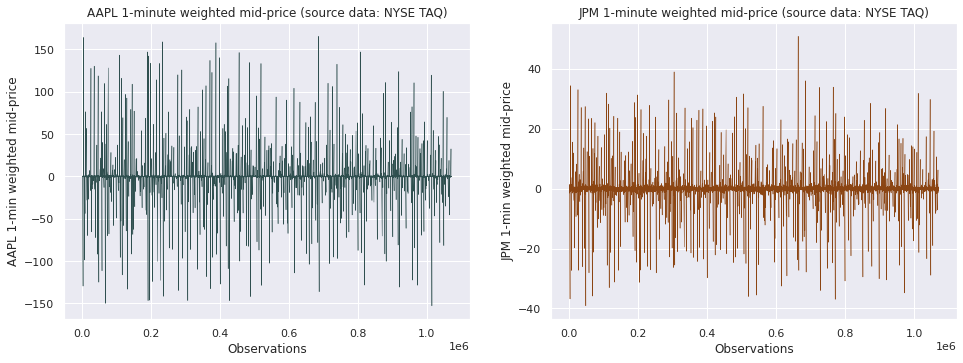

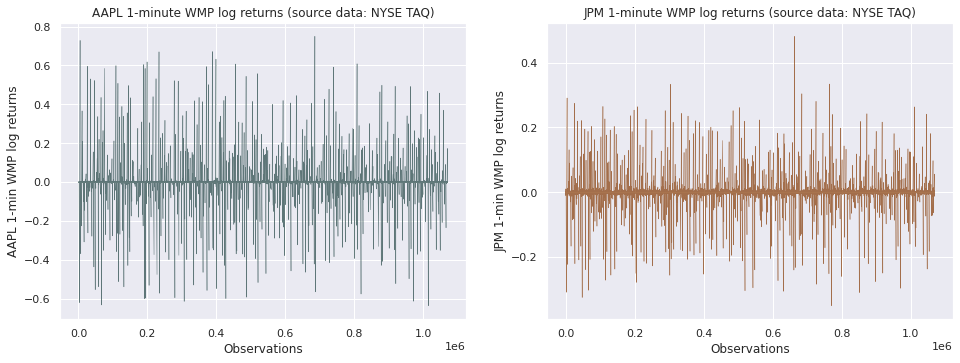

In [5]:
# Returns plots
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns   
sns.set()

startEndTimes = ['2018-01-01 00:00:00.0', '2020-03-31 23:59:59.0']
startTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[0])
endTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[1])
startDate = str(startTime.date()).replace('-','.')
endDate = str(endTime.date()).replace('-','.')
currentTime = str(date.today())

fig = plt.figure(figsize=(16,12))  

ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(AAPL_rr, color='darkslategrey', linewidth=0.5)

ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(JPM_rr, color='saddlebrown', linewidth=0.5)

plt.show();

# Log returns plots
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(AAPL_lr, color='darkslategrey', linewidth=0.5, alpha=0.75)

ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(JPM_lr, color='saddlebrown', linewidth=0.5, alpha=0.75)

plt.show();

In [15]:
unique_values = df_data_AAPL['WeightedMidPrice'].unique()
print("Unique values in 'WeightedMidPrice' field:")
print(unique_values)


Unique values in 'WeightedMidPrice' field:
['280.21' '280.07' '280.46' ... '148.94' '149.58' '146.53']


In [17]:
column_dtype = df_data_AAPL['WeightedMidPrice'].dtype
print("Datatype of 'WeightedMidPrice':", column_dtype)

Datatype of 'WeightedMidPrice': object


In [ ]:
df_data_AAPL['WeightedMidPrice'] = pd.to_numeric(df_data_AAPL['WeightedMidPrice'], errors='coerce')


# plot returns from scratch

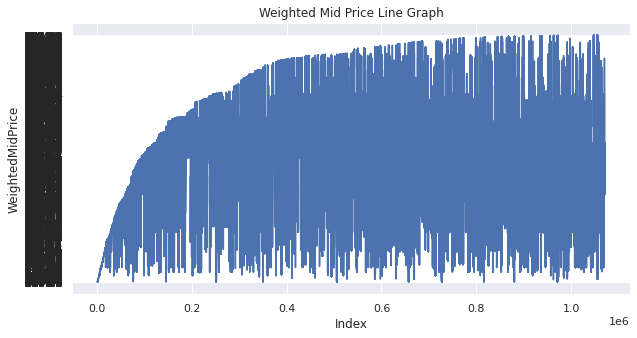

In [13]:
    plt.figure(figsize=(10, 5))
    plt.plot(df_data_AAPL['WeightedMidPrice'])
    plt.xlabel('Index')
    plt.ylabel('WeightedMidPrice')
    plt.title('Weighted Mid Price Line Graph')
    plt.show()

# plot returns using v0.1.5 code

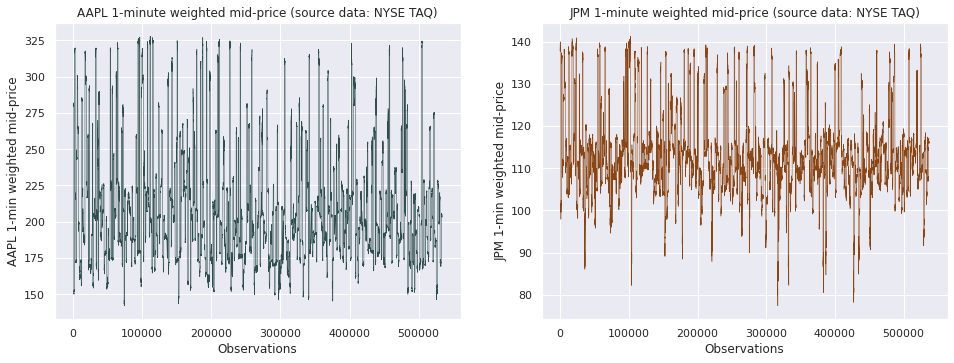

In [18]:
# Returns plots
from datetime import datetime, timedelta, date
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns   
sns.set()

# df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats = high_frequency_data()

startEndTimes = ['2018-01-01 00:00:00.0', '2020-03-31 23:59:59.0']
startTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[0])
endTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[1])
startDate = str(startTime.date()).replace('-','.')
endDate = str(endTime.date()).replace('-','.')
currentTime = str(date.today())

fig = plt.figure(figsize=(16,12))  

j = df_data_AAPL['WeightedMidPrice']
j = pd.to_numeric(df_data_AAPL['WeightedMidPrice'], errors='coerce')  # convert to numeric to avoid problem with UNK values
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(j, color='darkslategrey', linewidth=0.5)

j = df_data_JPM
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(j, color='saddlebrown', linewidth=0.5)

plt.show();


In [ ]:
# Log returns plots
from scipy import stats
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(16,12))  

# Log returns (NB: shown without removal of outliers)
AAPL_lr = df_data.loc[df_data['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = df_data.loc[df_data['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()

j = np.array(AAPL_lr).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(j, color='darkslategrey', linewidth=0.5, alpha=0.75)

j = np.array(JPM_lr).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(j, color='saddlebrown', linewidth=0.5, alpha=0.75)

plt.show();

#### Create text file for input to NanoGPT

In [6]:
# save df_data_AAPL and df_data_JPM as a text file with a comma delimiter

df_data_AAPL.to_csv('df_data_AAPL.txt', sep=',', index=False)
df_data_JPM.to_csv('df_data_JPM.txt', sep=',', index=False)

#### From ChatGPT re structure of text file:

> "In this example, we first create a sample dataframe called df. We then use the to_csv method to save the dataframe to a file called data.txt. The sep parameter specifies the delimiter to use in the text file (in this case, a tab character), and the index parameter is set to False to exclude the index from the output.  You can customize the parameters of to_csv method as per your requirements."

#### My next prompt: 

> I shall use data.txt as an input to a large language model (Karpathy's NanoGPT).  Should I include the sep='/t' parameter?

#### ChatGPT:

> "Yes, you should include the sep='\t' parameter in the to_csv method to specify the delimiter as a tab character. <br> <br>
> If the input file for Karpathy's NanoGPT expects tab-separated values, you need to ensure that the file you're providing is also in the same format. In the example I provided earlier, the sep='\t' parameter specifies that the data will be saved as tab-separated values. <br> <br>
> Therefore, including this parameter will ensure that the saved text file has a tab-separated format, which is the expected format for input to Karpathy's NanoGPT."

# MODIFY volgpt_data.py SO THAT df_data_AAPL and df_data_JPM CONTAIN ON THE COLUMNS FOR RAW RETURNS AND LOG RETURNS THAT ARE RELEVANT TO APPL AND JPM RESPECTIVELY

# SHAPES BELOW ARE WRONG - SEE DESCRIPTIVE STATISTICS ABOVE

In [7]:
# Check that the text file was saved correctly

df_exported_AAPL = pd.read_csv('df_data_AAPL.txt', sep=',') # read the text file into a dataframe
df_exported_JPM = pd.read_csv('df_data_JPM.txt', sep=',') # read the text file into a dataframe

print('shape of df_data_AAPL: ', df_data_AAPL.shape)
print('shape of df_exported_AAPL: ', df_exported_AAPL.shape)
print('shape of df_data_AAPL: ', df_data_AAPL.shape)
print('shape of df_exported_AAPL: ', df_exported_AAPL.shape)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,2,3,4,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


shape of df_data_AAPL:  (533860, 9)
shape of df_exported_AAPL:  (533860, 9)
shape of df_data_AAPL:  (533860, 9)
shape of df_exported_AAPL:  (533860, 9)


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Load data into NanoGPT

#### __[See nanogpt/nanogpt.ipynb commit v0.1.18 for consolidated code](https://github.com/johncollinsai/nanogpt/blob/bc54688a22dbce92648ad36fec865140ab1d6544/nanogpt.ipynb)__

# NOTE ONLY WORKING ON AAPL FOR NOW ... NEED TO INCLUDE JPM, PERHAPS AFTER MOVING MODEL TO A PYTHON FILE?

In [8]:
# See nanogpt/nanogpt.ipynb commit v0.1.18 for consolidated code
# https://github.com/johncollinsai/nanogpt/blob/bc54688a22dbce92648ad36fec865140ab1d6544/nanogpt.ipynb

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(3407)

# get data
with open('df_data_AAPL.txt', 'r', encoding='utf-8') as f: # NOTE THIS IS JUST AAPL FOR NOW
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.207149 M parameters
step 0: train loss 3.9746, val loss 3.9674
step 100: train loss 1.6802, val loss 1.6603
step 200: train loss 1.2505, val loss 1.2406
step 300: train loss 1.0464, val loss 1.0290
step 400: train loss 0.9432, val loss 0.9423
step 500: train loss 0.9198, val loss 0.9133
step 600: train loss 0.9057, val loss 0.8926
step 700: train loss 0.8844, val loss 0.8759
step 800: train loss 0.8794, val loss 0.8695
step 900: train loss 0.8744, val loss 0.8633
step 1000: train loss 0.8692, val loss 0.8638
step 1100: train loss 0.8643, val loss 0.8542
step 1200: train loss 0.8574, val loss 0.8542
step 1300: train loss 0.8504, val loss 0.8515
step 1400: train loss 0.8519, val loss 0.8564
step 1500: train loss 0.8482, val loss 0.8380
step 1600: train loss 0.8497, val loss 0.8444
step 1700: train loss 0.8442, val loss 0.8342
step 1800: train loss 0.8339, val loss 0.8382
step 1900: train loss 0.8405, val loss 0.8271
step 2000: train loss 0.8274, val loss 0.8195
step 2100: train loss 0.

#### Generate tick data

The decode() function is used to convert the output produced by m.generate() from the list of token IDs to a human-readable string. The output of m.generate() is a tensor of long integers, which is converted to a Python list with .tolist(). Then, the resulting list is passed as an argument to decode(), which uses volGPT's trained bigram language model to convert the token IDs to the corresponding text representations. Finally, the output of decode() is assigned to the variable pred.

> I generate 10k tokens, and then decode the tokens into a string. The output string, pred, contains a list of financial data points, including stock names (e.g., AAPL, JPM), timestamps, and the various numerical values. Each row of data starts with the stock symbol (e.g., AAPL or JPM), followed by a timestamp (e.g., 10:01:00.000000000 or 17:19:00.000000000). After the timestamp, the other data are separated by commas. 

In [9]:
# generate 10k tokens from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
pred = decode(m.generate(context, max_new_tokens=10000)[0].tolist())
print(pred)


AAPL,100.0,100.0,200.2,200.32,2019-10-04 16:04:00,290.39,0.0,0.0
AAPL,100.0,100.0,195.03,191.23,2018-07-08 17:04:00,191.39,-0.02,-0.0
AAPL,200.0,500.0,193.38,193.31,2019-06-25 07:13:00,193.34,0.18,0.40,0.0
AAPL,200.0,400.0,158.32,148.48,2019-01-26 04:08:00,138.44,-0.15,-0.0
AAPL,100.0,5800.0,317.78,307.87,2019-01-08 05:47:00,307.81,-0.18,-0.0
AAPL,500.0,2100.0,219.45,219.41,2019-09-05 15:32:00,211.51,0.07,0.0
AAPL,1300.0,500.0,175.61,175.18,2018-12-04 28:57:00,175.27,0.0,0.0
AAPL,1400.0,200.0,157.74,157.82,2019-11-05 14:58:00,157.83,-0.05,-0.0
AAPL,400.0,100.0,177.01,177.06,2018-01-11 16:13:00,177.01,-0.08,-0.0
AAPL,100.0,100.0,490.75,190.82,2019-07-15 16:35:00,190.89,-0.01,-0.0
AAPL,1500.0,1500.0,246.31,246.59,2020-01-28 15:17:00,247.52,0.0,0.0
AAPL,100.0,100.0,140.4,141.12,141.35,2018-10-04 06:25:00,142.3,-0.01,-0.0
AAPL,400.0,500.0,225.41,225.55,2019-10-16 02:27:00,225.56,0.03,0.0
AAPL,400.0,100.0,171.3,172.48,2019-02-03 09:47:00,172.39,-0.03,-0.0
AAPL,200.0,100.0,198.05,198.35,201

# SEE CHATGPT "MZ regression for Stocks" for the next steps. 

In [10]:
# Evaluate the model using MZ regression
from mz import perform_mz_regression
df, df_clean, rr_results, lr_results = perform_mz_regression(pred)

print("Original DataFrame:")
print(df)

print("\nCleaned DataFrame:")
print(df_clean)

print("MZ Regression for rr:")
print(rr_results.summary())

print("\nMZ Regression for lr:")
print(lr_results.summary())

Original DataFrame:
    Ticker  CloseBidSize  CloseAskSize  CloseBidPrice CloseAskPrice             DateTime WeightedMidPrice    rr   lr
0     AAPL         100.0         100.0         200.20        200.32  2019-10-04 16:04:00           290.39  0.00  0.0
1     AAPL         100.0         100.0         195.03        191.23  2018-07-08 17:04:00           191.39 -0.02 -0.0
2     AAPL         200.0         500.0         193.38        193.31  2019-06-25 07:13:00           193.34  0.18  0.4
3     AAPL         200.0         400.0         158.32        148.48  2019-01-26 04:08:00           138.44 -0.15 -0.0
4     AAPL         100.0        5800.0         317.78        307.87  2019-01-08 05:47:00           307.81 -0.18 -0.0
..     ...           ...           ...            ...           ...                  ...              ...   ...  ...
143   AAPL         100.0         400.0         200.52        200.95  2019-08-00 06:36:00           200.44  0.05  0.0
144   AAPL        1300.0        3300.0      

# NEXT STEPS | TUESDAY

> * Compute MZ regressions using GPT4
> * Visualizations

# Compare to GPT4

# Visualize the results

***
# End